In [9]:
import gzip
import shutil
import zipfile

# gzip 文件路径
gz_file_path = '/GPUFS/sysu_htlin_3/tester01.zip.gz'
zip_file_path = '/GPUFS/sysu_htlin_3/tester01.zip'
target_path = '/GPUFS/sysu_htlin_3/tester01' 

# 首先解压 gzip 文件
with gzip.open(gz_file_path, 'rb') as f_in:
    with open(zip_file_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# 然后解压 zip 文件
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

print("解压完成")

解压完成


In [11]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 数据集路径
data_path = '/GPUFS/sysu_htlin_3/tester01/tester01'
classes = ['cataract', 'normal', 'surgery']

# 创建训练、验证和测试目录
for set_type in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(data_path, set_type, cls), exist_ok=True)

# 划分数据集
for cls in classes:
    images = os.listdir(os.path.join(data_path, cls))
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

    # 复制文件到相应目录
    for image in train_images:
        shutil.copy(os.path.join(data_path, cls, image), os.path.join(data_path, 'train', cls))
    for image in val_images:
        shutil.copy(os.path.join(data_path, cls, image), os.path.join(data_path, 'val', cls))
    for image in test_images:
        shutil.copy(os.path.join(data_path, cls, image), os.path.join(data_path, 'test', cls))

# 创建数据生成器
# 创建训练数据生成器
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

# 创建验证数据生成器
val_datagen = ImageDataGenerator(rescale=1./255)

# 创建测试数据生成器
test_datagen = ImageDataGenerator(rescale=1./255)

# 加载数据
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical' 
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2450 images belonging to 3 classes.
Found 306 images belonging to 3 classes.
Found 308 images belonging to 3 classes.


In [21]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 创建模型，不加载预训练权重
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))

# 加载之前手动下载的权重
weights_path = '/GPUFS/sysu_htlin_3/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(weights_path)

# 冻结模型的所有层
for layer in base_model.layers:
    layer.trainable = False

# 添加自定义层
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
predictions = Dense(3, activation='softmax')(x) 

# 构建最终模型
model = Model(inputs=base_model.input, outputs=predictions)

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
77/77 [==============================] - 43s 475ms/step - loss: 0.5465 - accuracy: 0.7690 - val_loss: 0.3334 - val_accuracy: 0.8791
Epoch 2/20
77/77 [==============================] - 34s 444ms/step - loss: 0.2901 - accuracy: 0.9045 - val_loss: 0.2259 - val_accuracy: 0.9379
Epoch 3/20
77/77 [==============================] - 35s 448ms/step - loss: 0.2388 - accuracy: 0.9192 - val_loss: 0.2110 - val_accuracy: 0.9118
Epoch 4/20
77/77 [==============================] - 34s 445ms/step - loss: 0.1970 - accuracy: 0.9355 - val_loss: 0.1735 - val_accuracy: 0.9379
Epoch 5/20
77/77 [==============================] - 35s 448ms/step - loss: 0.1930 - accuracy: 0.9343 - val_loss: 0.1642 - val_accuracy: 0.9379
Epoch 6/20
77/77 [==============================] - 34s 436ms/step - loss: 0.1694 - accuracy: 0.9380 - val_loss: 0.1596 - val_accuracy: 0.9379
Epoch 7/20
77/77 [==============================] - 35s 448ms/step - loss: 0.1539 - accuracy: 0.9494 - val_loss: 0.1350 - val_accuracy: 0.9575

10/10 [==============================] - 2s 199ms/step - loss: 0.1128 - accuracy: 0.9575
Validation accuracy: 95.75%
10/10 [==============================] - 10s 1s/step - loss: 0.0771 - accuracy: 0.9740
Test accuracy: 97.40%


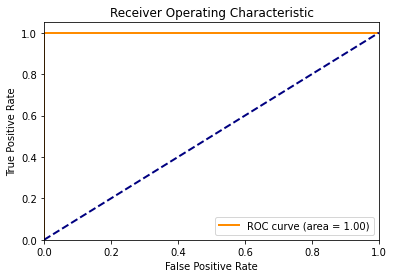

In [22]:
# 评估模型在验证集上的表现
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

# 评估模型在测试集上的表现
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# 获取测试数据和标签
test_images, test_labels = next(test_generator)

# 预测测试集
predictions = model.predict(test_images)

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
# 保存模型
model.save('cataract_model_DenseNet121.h5')